In [ ]:
# # COCO Dataset wget images ( train/val/test )
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/zips/test2017.zip

# # COCO Dataset wget annotations ( train/val/test )
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/image_info_test2017.zip


In [ ]:
!mkdir /content/data

# !unzip /content/annotations_trainval2017.zip -d /content/data


# !unzip /content/test2017.zip -d /content/data
# !unzip /content/train2017.zip -d /content/data
# !unzip /content/val2017.zip -d /content/data

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 14465, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 14465 (delta 15), reused 26 (delta 12), pack-reused 14425
Receiving objects: 100% (14465/14465), 5.92 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (10460/10460), done.


In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 20 kB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.5.0+cu101

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 493 kB/s 
     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 42 kB 990 kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=ac56beded04ad6e19788dd38d30fa39fd59cd11248c1ef50048c8f4774924e4a
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=6d814763fd9f45e0fb51d477e8392d2ee38ea9da4cbd4fb3b9dbf542eff2355a
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


# Model Detectron2 Setting



In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.config import get_cfg
import random
from detectron2.utils.visualizer import Visualizer
import os

from detectron2.utils.visualizer import ColorMode
import glob
from matplotlib.image import imread
import scipy.misc
from PIL import Image
import time

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "/content/data/annotations/instances_train2017.json", "/content/data/train2017")
register_coco_instances("my_dataset_val", {}, "/content/data/annotations/instances_val2017.json", "/content/data/val2017")
# register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Train

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Inference Run

## pretrain weight down

In [ ]:
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl

--2022-07-26 04:00:42--  https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431414189 (411M) [application/octet-stream]
Saving to: ‘model_final_2d9806.pkl’

model_final_2d9806. 100%[===================>] 411.43M  14.4MB/s    in 39s     

2022-07-26 04:01:21 (10.6 MB/s) - ‘model_final_2d9806.pkl’ saved [431414189/431414189]



## Inference cfg

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = '/content/data/output/'

cfg.merge_from_file("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "/content/model_final_2d9806.pkl"

cfg.DATASETS.TEST = ("my_dataset_test", )

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")


RuntimeError: ignored

In [ ]:
!mkdir /content/data/test2017

## Mask Img Save

In [ ]:
!mkdir /content/data/output

In [ ]:
def cropper(org_image_path, mask_array, out_file_name):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    img = imread(str(org_image_path))
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)

    im = Image.fromarray(output)
    im.save(out_file_name)

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
from matplotlib.image import imread
import scipy.misc
from PIL import Image
import time

img_list = os.listdir('/content/data/test2017/')

for imageName in img_list:
    im = cv2.imread('/content/data/test2017/' + imageName)
    
    h, w, _ = im.shape

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=1,
                # instance_mode=ColorMode.IMAGE_BW # 굳이 필욘 없네 # remove the colors of unsegmented pixels. This option is only available for segmentation models
                    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    boxes = v._convert_boxes(outputs["instances"].pred_boxes.to('cpu')).squeeze()

    for idx, box in enumerate(boxes):
        out = v.draw_text(f"{idx}", ((box[0]+box[2])/2, (box[1]+box[3])/2), font_size = h//40, color = 'g') # 0번부터 아니고 1번부터 시작으로 할 수 있을 듯 (사용자 편의)

    cv2_imshow(out.get_image()[:, :, ::-1])

    # 사진이 print되는데 시간이 걸려서 대기시간 줌
    time.sleep(5)

#############

    mask = outputs['instances'].pred_masks
   

    print(' ","로 구분해주세요 ')
    select = map(int, input().split(','))
    select = list(select)

    tensor_list = []
   
    for a in select :
        tensor_list.append(mask[a])                           # 만약 idx+1 하면 select값에서 1을 빼야함
        
    tensor_stack = torch.stack(tensor_list)


    img_root = '/content/data/test2017/'
    img_path = img_root + imageName
    out_root = '/content/data/output/'
    out_path = out_root + imageName.split('.')[0] +'_mask.png'

    mask_array = tensor_stack.cpu().numpy()
    cropper(img_path, mask_array, out_path)


 연결
 

In [ ]:
# 깃허브 repository 가져오기
!git clone https://github.com/saic-mdal/lama.git

# 라이브러리 설치
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet

# 경로이동
%cd /content/lama
!mkdir -p /content/lama/data_for_prediction/

# weight 다운로드
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

# 라이브러리 설치
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet

# 라이브러리 호출
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

# 그림 그리는 함수 선언
def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
    

fatal: destination path 'lama' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████▌                  | 834.1 MB 70.0 MB/s eta 0:00:17tcmalloc: large alloc 1147494400 bytes == 0x3a4fe000 @  0x7f373cb24615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:41tcmalloc: large alloc 1434370048 bytes == 0x7eb54000 @  0x7f373cb24615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
  

In [ ]:
coco = 'person,bicycle,car,motorbike,aeroplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,baseball glove,skateboard,surfboard,tennis racket,bottle,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush'

coco = coco.split(',')
coco

coco_dic = {}
for idx, aa in enumerate(coco) :
    coco_dic[str(idx)] = aa

In [ ]:
img_list = os.listdir('/content/data/test2017/')

for imageName in img_list:
    im = cv2.imread('/content/data/test2017/' + imageName)
    
    h, w, _ = im.shape

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=1,
                # instance_mode=ColorMode.IMAGE_BW # 굳이 필욘 없네 # remove the colors of unsegmented pixels. This option is only available for segmentation models
                    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    boxes = v._convert_boxes(outputs["instances"].pred_boxes.to('cpu')).squeeze()


    for idx, box in enumerate(boxes):
        pred_class_num = outputs['instances'][idx].pred_classes.tolist()[0]
        class_text = coco_dic[str(pred_class_num)]
        out = v.draw_text(f"{idx} : {class_text}", ((box[0]+box[2])/2, (box[1]+box[3])/2), font_size = h//40, color = 'g') # 0번부터 아니고 1번부터 시작으로 할 수 있을 듯 (사용자 편의)


    cv2_imshow(out.get_image()[:, :, ::-1])

    # 사진이 print되는데 시간이 걸려서 대기시간 줌
    time.sleep(5)

#############

    mask = outputs['instances'].pred_masks
   
    print('1번 : 내가 원하는 물체 골라서 지우기')
    print('2번 : 내가 원하는 물체만 남기고 나머지 다 지우기')
    print('3번 : 내가 원하는 물체 종류를 한번에 지우기')
    print('4번 : 내가 원하는 물체 종류를 남기고 나머지 다 지우기')

    cate = int(input('원하는 업무의 번호만 입력하세요. : '))


    while 1 :
        if cate == 1 or cate == 2 or cate == 3 or cate == 4 :
            break
        elif cate == '1번' or cate == '2번' or cate == '3번' or cate == '4번' :
            break
        else :
            cate = int(input('원하는 업무의 번호만 다시 입력하세요. : '))
        
    if cate == 1 or cate == '1번' :

        print('지우고 싶은 물체 번호를 ","로 구분해 입력해주세요')
        select = map(int, input().split(','))
        select = list(select)

        tensor_list = []
    
        for a in select :
            tensor_list.append(mask[a])                           # 만약 idx+1 하면 select값에서 1을 빼야함
            
        tensor_stack = torch.stack(tensor_list)


        img_root = '/content/data/test2017/'
        img_path = img_root + imageName
        out_root = '/content/data/output/'
        out_path = out_root + imageName

        mask_array = tensor_stack.cpu().numpy()
        cropper(img_path, mask_array, out_path)

        shutil.copy(img_path, '/content/lama/data_for_prediction/')
        cv2.imwrite('/content/lama/data_for_prediction/'+imageName.split('.')[0] +'_mask.png', cv2.imread(out_path))
    

    elif cate == 2 or cate == '2번' :
        ### 오류이려나
        tensor_full_list = [x for x in range(len(boxes))]

        print('남기고 싶은 물체 번호를 ","로 구분해 입력해주세요')

        select = map(int, input().split(','))
        select = list(set(tensor_full_list) - set(select))

        tensor_list = []

        for a in select :
            tensor_list.append(mask[a])                           # 만약 idx+1 하면 select값에서 1을 빼야함
            
        tensor_stack = torch.stack(tensor_list)


        img_root = '/content/data/test2017/'
        img_path = img_root + imageName
        out_root = '/content/data/output/'
        out_path = out_root + imageName

        mask_array = tensor_stack.cpu().numpy()
        cropper(img_path, mask_array, out_path)

        shutil.copy(img_path, '/content/lama/data_for_prediction/')
        cv2.imwrite('/content/lama/data_for_prediction/'+imageName.split('.')[0] +'_mask.png', cv2.imread(out_path))


    elif cate == 3 or cate == '3번' :

        class_cate = outputs['instances'].to('cpu').pred_classes.tolist()
        class_cate = list(set(class_cate))


        for c in class_cate :
            print(f'{c} : {coco_dic[str(c)]}')
        
        
        print('지우고 싶은 물체 종류의 번호를 ","로 구분해 입력해주세요 ')
        select = map(int, input().split(','))

        tensor_list = []

        for idx in len(outputs['instances']) :
            if outputs['instances'][idx].pred_classes.tolist()[0] in select :
                tensor_list.append(mask[idx])
            
        tensor_stack = torch.stack(tensor_list)

        img_root = '/content/data/test2017/'
        img_path = img_root + imageName
        out_root = '/content/data/output/'
        out_path = out_root + imageName

        mask_array = tensor_stack.cpu().numpy()
        cropper(img_path, mask_array, out_path)

        shutil.copy(img_path, '/content/lama/data_for_prediction/')
        cv2.imwrite('/content/lama/data_for_prediction/'+imageName.split('.')[0] +'_mask.png', cv2.imread(out_path))




    elif cate == 4 or cate == '4번' :

        class_cate = outputs['instances'].to('cpu').pred_classes.tolist()
        class_cate = list(set(class_cate))


        for c in class_cate :
            print(f'{c} : {coco_dic[str(c)]}')
        
        
        print('남기고 싶은 물체 종류의 번호를 ","로 구분해 입력해주세요 ')
        select = map(int, input().split(','))
        select = list(set(class_cate) - set(select))


        tensor_list = []

        for idx in len(outputs['instances']) :
            if outputs['instances'][idx].pred_classes.tolist()[0] in select :
                tensor_list.append(mask[idx])
            
        tensor_stack = torch.stack(tensor_list)

        img_root = '/content/data/test2017/'
        img_path = img_root + imageName
        out_root = '/content/data/output/'
        out_path = out_root + imageName

        mask_array = tensor_stack.cpu().numpy()
        cropper(img_path, mask_array, out_path)

        shutil.copy(img_path, '/content/lama/data_for_prediction/')
        cv2.imwrite('/content/lama/data_for_prediction/'+imageName.split('.')[0] +'_mask.png', cv2.imread(out_path))





In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)

# 원본이미지 경로
# 마스크된 이미지는 png로 만들어야함

for imageName in img_list: 

    fname = './data_for_prediction/' + imageName

    if '.jpeg' in fname:
        !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
    elif '.jpg' in fname:
        !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
    elif '.png' in fname:
        !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
    else:
        print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

    plt.rcParams['figure.dpi'] = 200
    
    # 출력데이터도 png
    plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
    _=plt.axis('off')
    _=plt.title('inpainting result')
    plt.show()
    fname = None

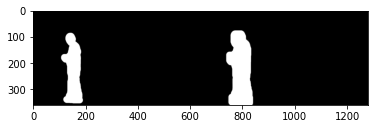

In [ ]:
# 팽창 연산 (morph_dilate.py)

import cv2
import numpy as np

img = cv2.imread('/content/KakaoTalk_20220726_152640563.png')

# 구조화 요소 커널, 사각형 (3x3) 생성 ---①
k = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
# 팽창 연산 적용 ---②
dst = cv2.dilate(img, k)

# 결과 출력
merged = np.hstack((img, dst))

plt.imshow(merged)
